# Script to compress existing models

In [1]:
import onnx
from onnx_tf.backend import prepare

import torchvision
import torch
import os
import numpy as np
import tensorflow as tf
import json
from PIL import Image
import onnx
import matplotlib.pyplot as plt

2023-12-19 10:31:21.782815: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-19 10:31:22.478761: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-19 10:31:23.778111: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-19 10:31:23.780974: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-19 10:31:39.600960: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
# set up the files you are interested in
image_file='/bask/homes/f/fspo1218/amber/data/gbif_download_standalone/gbif_images/Noctuidae/Spodoptera/Spodoptera exigua/1211977745.jpg'

# Label info for the species names for the uk macro moths
f = open("/bask/homes/f/fspo1218/amber/data/gbif_costarica/01_costarica_data_numeric_labels.json")
label_info = json.load(f)
label_info = label_info['species_list']
species_list_mila = list(label_info)
print(len(species_list_mila), " species in total")

num_classes = len(species_list_mila)

PATH = "/bask/homes/f/fspo1218/amber/projects/on_device_classifier/outputs/turing-costarica_v02_resnet50_2023-12-15-10-51.pt"
device = torch.device('cpu')

output_dir = '/bask/homes/f/fspo1218/amber/data/compressed_models/gbif_costarica/'
os.makedirs(output_dir, exist_ok=True)

5952  species in total


In [3]:
def pytorch_to_tflite(model, output_dir, image, output_model_prefix="model"):
    
    # convert the model to onnx
    print("Converting to onnx")
    
    onnx_path = output_dir + "/" + output_model_prefix + ".onnx"
    torch.onnx.export(
            model=model.eval(),
            args=image.unsqueeze(0),
            f=onnx_path,
            verbose=False,
            export_params=True,
            do_constant_folding=False,
            input_names=['input'],
            opset_version=12,
            output_names=['output']
    )
    
    # Convert to tf
    print("Converting to tensorflow...")
    tf_path = output_dir + "/tf_" + output_model_prefix  
    onnx_model = onnx.load(onnx_path)
    onnx.checker.check_model(onnx_model)
    tf_rep = prepare(onnx_model, device='CPU')
    tf_rep.export_graph(tf_path)
    
    # Convert to tfLite
    print("Converting to tensorflowlite")
    converter = tf.lite.TFLiteConverter.from_saved_model(tf_path)
    converter.experimental_new_converter = True
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
    converter.allow_custom_ops=True
    tflite_model = converter.convert()
    
    print("Saving converted model")
    with open(output_dir + "/" + output_model_prefix + ".tflite", 'wb') as f:
        f.write(tflite_model)
        
    return tflite_model

## MILA species classifier

In [4]:
image = Image.open(image_file)

# Transform
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((300, 300)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]
)
img = transform(image)


In [5]:
import torch, torchvision

import sys
sys.path.append('/bask/homes/f/fspo1218/amber/projects/on_device_classifier/')
sys.path.append('/bask/homes/f/fspo1218/amber/projects/on_device_classifier/models/')
sys.path.append('/bask/homes/f/fspo1218/amber/projects/on_device_classifier/data2/')
sys.path.append('/bask/homes/f/fspo1218/amber/projects/on_device_classifier/evaluation/')

from data2 import dataloader
import evaluation

In [6]:
if 'efficientnet' in PATH:
    model_py_mila = models.efficientnet_b0(pretrained=True)
    model_py_mila = model_py_mila.to(device)
    checkpoint = torch.load(PATH, map_location=device)
    model_py_mila.eval()
    
elif 'resnet' in PATH:
    model_py_mila = torchvision.models.resnet50(weights=None)
    num_ftrs = model_py_mila.fc.in_features
    model_py_mila.fc = torch.nn.Linear(num_ftrs, num_classes)
    model_py_mila = model_py_mila.to(device)
    model_py_mila = torch.load(PATH, map_location=device)
    model_py_mila.eval()
    
else:
    print('clarify model type')

print("loaded MILA model")

loaded MILA model


In [7]:
tflite_model = pytorch_to_tflite(model_py_mila, 
                  output_dir=output_dir,
                  image=img, 
                  output_model_prefix="resnet_costarica")

Converting to onnx
============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Converting to tensorflow...


INFO:absl:Function `__call__` contains input name(s) x, y with unsupported characters which will be renamed to onnx_tf_prefix__classifier_transpose_x, add_52_y in the SavedModel.
INFO:absl:Found untraced functions such as gen_tensor_dict while saving (showing 1 of 1). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /bask/homes/f/fspo1218/amber/data/compressed_models/gbif_costarica//tf_resnet_costarica/assets


INFO:tensorflow:Assets written to: /bask/homes/f/fspo1218/amber/data/compressed_models/gbif_costarica//tf_resnet_costarica/assets
INFO:absl:Writing fingerprint to /bask/homes/f/fspo1218/amber/data/compressed_models/gbif_costarica//tf_resnet_costarica/fingerprint.pb


Converting to tensorflowlite


2023-12-19 10:32:54.923675: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-12-19 10:32:54.923713: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-12-19 10:32:54.924558: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /bask/homes/f/fspo1218/amber/data/compressed_models/gbif_costarica//tf_resnet_costarica
2023-12-19 10:32:54.968084: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-12-19 10:32:54.968122: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /bask/homes/f/fspo1218/amber/data/compressed_models/gbif_costarica//tf_resnet_costarica
2023-12-19 10:32:55.047380: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2023-12-19 10:32:55.049006: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-12-1

Saving converted model


In [8]:
os.path.getsize(PATH) / 1e6

143.147498

### Example Inference

(-0.5, 299.5, 299.5, -0.5)

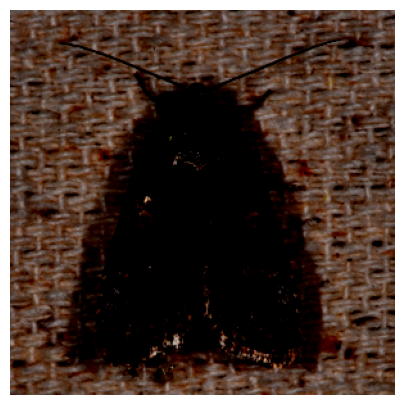

In [44]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))

axs.imshow(img.permute(1, 2, 0))
axs.axis('off')

In [10]:
import datetime

def pytorch_inference(image, test_model, print_time=False):
    a = datetime.datetime.now()
    output = test_model(image.unsqueeze(0))
    predictions = torch.nn.functional.softmax(output, dim=1)
    predictions = predictions.detach().numpy()

    categories = predictions.argmax(axis=1)
    #print(categories)
    b = datetime.datetime.now()
    c = b - a
    if print_time: print(str(c.microseconds) + "\u03bcs")
    return(categories[0])
    
def tflite_inference(image, interpreter, print_time=False):
    a = datetime.datetime.now()
    interpreter.set_tensor(input_details[0]['index'], image.unsqueeze(0))
    interpreter.invoke()
    outputs_tf = interpreter.get_tensor(output_details[0]['index'])
    prediction_tf = np.squeeze(outputs_tf)
    prediction_tf = prediction_tf.argsort()[::-1][0]
    #print(prediction_tf)
    b = datetime.datetime.now()
    c = b - a
    if print_time: print(str(c.microseconds) + "\u03bcs")
    return(prediction_tf)
        

In [11]:
pytorch_inf = pytorch_inference(img, model_py_mila)

In [12]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=os.path.join(output_dir, 'resnet_costarica.tflite'))

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [13]:
tflite_inf = tflite_inference(img, interpreter)

In [14]:
print('TFlite says', species_list_mila[tflite_inf])
print('Pytorch says', species_list_mila[pytorch_inf])
print('Truth says', os.path.basename(os.path.dirname(image_file)))

TFlite says Oxydia geminata
Pytorch says Oxydia geminata
Truth says Spodoptera exigua


# Inference on Test Data

In [15]:
config_file = '/bask/homes/f/fspo1218/amber/projects/on_device_classifier/configs/01_costarica_data_config.json'
f = open(config_file)
config_data = json.load(f)

In [16]:
image_resize = config_data["training"]["image_resize"]
batch_size = config_data["training"]["batch_size"]
label_list = config_data["dataset"]["label_info"]
preprocess_mode = config_data["model"]["preprocess_mode"]
taxon_hierar = config_data["dataset"]["taxon_hierarchy"]
label_info= config_data["dataset"]["label_info"]

# Load in the test data
test_dataloader = dataloader.build_webdataset_pipeline(
        sharedurl="/bask/homes/f/fspo1218/amber/data/gbif_costarica/test/test-500-{000000..000008}.tar",
        input_size=image_resize,
        batch_size=batch_size,
        is_training=False,
        num_workers=4,
        preprocess_mode=preprocess_mode,
    )
print("images loaded")

images loaded


In [17]:
interpreter = tf.lite.Interpreter(model_path=os.path.join(output_dir, 'resnet_costarica.tflite'))

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.allocate_tensors()

In [18]:
# Define your preprocess_for_tflite and postprocess_for_tflite functions accordingly
def preprocess_for_tflite(image_batch):
    return np.array(image_batch)

def postprocess_for_tflite(output_data):
    return torch.tensor(output_data)

In [19]:
from evaluation import micro_accuracy_batch
from evaluation import macro_accuracy_batch
from evaluation import confusion_data_conversion
from evaluation import confusion_matrix_data

In [20]:
no_iterations = sum(1 for _ in enumerate(test_dataloader))

print('There are ', no_iterations, ' iterations')

There are  94  iterations


PSA: the next cell takes around 20 mins for 94 batches (64 images each)

In [21]:
py_global_microacc_data = None
py_global_macroacc_data = None
py_global_confusion_data_sp = None
py_global_confusion_data_g = None
py_global_confusion_data_f = None

tf_global_microacc_data = None
tf_global_macroacc_data = None
tf_global_confusion_data_sp = None
tf_global_confusion_data_g = None
tf_global_confusion_data_f = None
i=1
    
for image_batch, label_batch in test_dataloader:
    print(i, '/', no_iterations)
    i = i + 1
    
    image_batch, label_batch = image_batch.to(device), label_batch.to(device)
    py_predictions = model_py_mila(image_batch)
    
    # Preprocess the input image_batch for TensorFlow Lite model
    # You need to replace this preprocessing logic based on your TensorFlow Lite model requirements
    input_data = preprocess_for_tflite(image_batch)
    
    # Run inference using TensorFlow Lite model for each image in the batch
    predictions_tflite_batch = []
    for single_input_data in input_data:
        single_input_data = np.expand_dims(single_input_data, axis=0)  # Add batch dimension
        interpreter.set_tensor(interpreter.get_input_details()[0]['index'], single_input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])
        predictions_tflite_batch.append(output_data)

    # Stack predictions for the entire batch
    predictions_tflite_batch = np.vstack(predictions_tflite_batch)

    # Assuming `postprocess_for_tflite` is a function to postprocess the output_data
    # You need to replace this postprocessing logic based on your TensorFlow Lite model requirements
    tf_predictions = postprocess_for_tflite(predictions_tflite_batch)
    
    #predictions_tf = predictions_tflite_batch#.argmax(axis=1)
    


    # Pytorch Metrics
    # micro-accuracy calculation
    py_micro_accuracy = micro_accuracy_batch.MicroAccuracyBatch(
        py_predictions, label_batch, label_info, taxon_hierar
    ).batch_accuracy()
    py_global_microacc_data = micro_accuracy_batch.add_batch_microacc(
        py_global_microacc_data, py_micro_accuracy
    )
    # macro-accuracy calculation
    py_macro_accuracy = macro_accuracy_batch.MacroAccuracyBatch(
        py_predictions, label_batch, label_info, taxon_hierar
    ).batch_accuracy()
    py_global_macroacc_data = macro_accuracy_batch.add_batch_macroacc(
        py_global_macroacc_data, py_macro_accuracy
    )

    # confusion matrix
    (
        py_sp_label_batch,
        py_sp_predictions,
        py_g_label_batch,
        py_g_predictions,
        py_f_label_batch,
        py_f_predictions,
    ) = confusion_data_conversion.ConfusionDataConvert(
        py_predictions, label_batch, label_info, taxon_hierar
    ).converted_data()

    py_global_confusion_data_sp = confusion_matrix_data.confusion_matrix_data(
        py_global_confusion_data_sp, [py_sp_label_batch, py_sp_predictions]
    )
    py_global_confusion_data_g = confusion_matrix_data.confusion_matrix_data(
        py_global_confusion_data_g, [py_g_label_batch, py_g_predictions]
    )
    py_global_confusion_data_f = confusion_matrix_data.confusion_matrix_data(
        py_global_confusion_data_f, [py_f_label_batch, py_f_predictions]
    )
    
    # TFLite Metrics
    # micro-accuracy calculation
    tf_micro_accuracy = micro_accuracy_batch.MicroAccuracyBatch(
        tf_predictions, label_batch, label_info, taxon_hierar
    ).batch_accuracy()
    tf_global_microacc_data = micro_accuracy_batch.add_batch_microacc(
        tf_global_microacc_data, tf_micro_accuracy
    )
    # macro-accuracy calculation
    tf_macro_accuracy = macro_accuracy_batch.MacroAccuracyBatch(
        tf_predictions, label_batch, label_info, taxon_hierar
    ).batch_accuracy()
    tf_global_macroacc_data = macro_accuracy_batch.add_batch_macroacc(
        tf_global_macroacc_data, tf_macro_accuracy
    )

    # confusion matrix
    (
        tf_sp_label_batch,
        tf_sp_predictions,
        tf_g_label_batch,
        tf_g_predictions,
        tf_f_label_batch,
        tf_f_predictions,
    ) = confusion_data_conversion.ConfusionDataConvert(
        tf_predictions, label_batch, label_info, taxon_hierar
    ).converted_data()

    tf_global_confusion_data_sp = confusion_matrix_data.confusion_matrix_data(
        tf_global_confusion_data_sp, [tf_sp_label_batch, tf_sp_predictions]
    )
    tf_global_confusion_data_g = confusion_matrix_data.confusion_matrix_data(
        tf_global_confusion_data_g, [tf_g_label_batch, tf_g_predictions]
    )
    tf_global_confusion_data_f = confusion_matrix_data.confusion_matrix_data(
        tf_global_confusion_data_f, [tf_f_label_batch, tf_f_predictions]
    )

1 / 94
2 / 94
3 / 94
4 / 94
5 / 94
6 / 94
7 / 94
8 / 94
9 / 94
10 / 94
11 / 94
12 / 94
13 / 94
14 / 94
15 / 94
16 / 94
17 / 94
18 / 94
19 / 94
20 / 94
21 / 94
22 / 94
23 / 94
24 / 94
25 / 94
26 / 94
27 / 94
28 / 94
29 / 94
30 / 94
31 / 94
32 / 94
33 / 94
34 / 94
35 / 94
36 / 94
37 / 94
38 / 94
39 / 94
40 / 94
41 / 94
42 / 94
43 / 94
44 / 94
45 / 94
46 / 94
47 / 94
48 / 94
49 / 94
50 / 94
51 / 94
52 / 94
53 / 94
54 / 94
55 / 94
56 / 94
57 / 94
58 / 94
59 / 94
60 / 94
61 / 94
62 / 94
63 / 94
64 / 94
65 / 94
66 / 94
67 / 94
68 / 94
69 / 94
70 / 94
71 / 94
72 / 94
73 / 94
74 / 94
75 / 94
76 / 94
77 / 94
78 / 94
79 / 94
80 / 94
81 / 94
82 / 94
83 / 94
84 / 94
85 / 94
86 / 94
87 / 94
88 / 94
89 / 94
90 / 94
91 / 94
92 / 94
93 / 94
94 / 94


In [35]:
label_read = json.load(open(label_list))

{'family_list': ['Hedylidae',
  'Attevidae',
  'Apatelodidae',
  'Crambidae',
  'Notodontidae',
  'Mimallonidae',
  'Phiditiidae',
  'Oecophoridae',
  'Sematuridae',
  'Blastobasidae',
  'Elachistidae',
  'Psychidae',
  'Sesiidae',
  'Noctuidae',
  'Depressariidae',
  'Doidae',
  'Castniidae',
  'Metarbelidae',
  'Cossidae',
  'Thyrididae',
  'Megalopygidae',
  'Uraniidae',
  'Opostegidae',
  'Pterophoridae',
  'Lasiocampidae',
  'Aididae',
  'Hepialidae',
  'Zygaenidae',
  'Eupterotidae',
  'Glyphipterigidae',
  'Stathmopodidae',
  'Gelechiidae',
  'Yponomeutidae',
  'Saturniidae',
  'Hyblaeidae',
  'Plutellidae',
  'Gracillariidae',
  'Bombycidae',
  'Brachodidae',
  'Urodidae',
  'Sphingidae',
  'Tortricidae',
  'Euteliidae',
  'Lacturidae',
  'Lyonetiidae',
  'Limacodidae',
  'Pyralidae',
  'Momphidae',
  'Dudgeoneidae',
  'Peleopodidae',
  'Alucitidae',
  'Adelidae',
  'Tineidae',
  'Erebidae',
  'Drepanidae',
  'Autostichidae',
  'Nolidae',
  'Geometridae',
  'Choreutidae',
  'Ep

In [37]:
import pandas as pd

py_final_micro_accuracy = micro_accuracy_batch.final_microacc(py_global_microacc_data)
py_final_macro_accuracy, py_taxon_acc = macro_accuracy_batch.final_macroacc(py_global_macroacc_data)

tf_final_micro_accuracy = micro_accuracy_batch.final_microacc(tf_global_microacc_data)
tf_final_macro_accuracy, tf_taxon_acc = macro_accuracy_batch.final_macroacc(tf_global_macroacc_data)

tf_tax_accuracy = macro_accuracy_batch.taxon_accuracy(tf_taxon_acc, label_read)
py_tax_accuracy = macro_accuracy_batch.taxon_accuracy(py_taxon_acc, label_read)

print(py_final_micro_accuracy, py_final_macro_accuracy)
print(tf_final_micro_accuracy, tf_final_macro_accuracy)

# saving evaluation data to file
confdata_pd_f = pd.DataFrame(
    {
        "F_Truth": py_global_confusion_data_f[0].reshape(-1),
        "F_Py_Prediction": py_global_confusion_data_f[1].reshape(-1),
        "F_Tf_Prediction": tf_global_confusion_data_f[1].reshape(-1),
    }
)
confdata_pd_g = pd.DataFrame(
    {
        "G_Truth": py_global_confusion_data_g[0].reshape(-1),
        "G_Py_Prediction": py_global_confusion_data_g[1].reshape(-1),
        "G_Tf_Prediction": tf_global_confusion_data_g[1].reshape(-1),
    }
)
confdata_pd_sp = pd.DataFrame(
    {
        "S_Truth": py_global_confusion_data_sp[0].reshape(-1),
        "S_Py_Prediction": py_global_confusion_data_sp[1].reshape(-1),
        "S_Tf_Prediction": tf_global_confusion_data_sp[1].reshape(-1),
    }
)
confdata_pd = pd.concat([confdata_pd_f, confdata_pd_g, confdata_pd_sp], axis=1)


{'micro_species_top1': 93.34, 'micro_species_top3': 97.53, 'micro_species_top10': 98.92, 'micro_genus_top1': 93.34, 'micro_genus_top3': 97.53, 'micro_genus_top10': 98.92, 'micro_family_top1': 94.61, 'micro_family_top3': 98.42, 'micro_family_top10': 99.55} {'macro_species_top1': 80.95, 'macro_species_top3': 88.95, 'macro_species_top10': 91.93, 'macro_genus_top1': 81.82, 'macro_genus_top3': 88.66, 'macro_genus_top10': 91.67, 'macro_family_top1': 93.93, 'macro_family_top3': 97.75, 'macro_family_top10': 99.16}
{'micro_species_top1': 93.22, 'micro_species_top3': 97.51, 'micro_species_top10': 98.94, 'micro_genus_top1': 93.24, 'micro_genus_top3': 97.51, 'micro_genus_top10': 98.94, 'micro_family_top1': 94.59, 'micro_family_top3': 98.42, 'micro_family_top10': 99.55} {'macro_species_top1': 80.55, 'macro_species_top3': 88.94, 'macro_species_top10': 91.94, 'macro_genus_top1': 81.51, 'macro_genus_top3': 88.65, 'macro_genus_top10': 91.68, 'macro_family_top1': 93.88, 'macro_family_top3': 97.69, 'macr

In [43]:
# save the outputs
 
confdata_pd.to_csv('./outputs/' + 'costarica_resnet' + "_v2.0" + "_confusion-data.csv", index=False)

with open(
    './outputs/' + 'costarica_resnet' + "_v2.0" + "_micro-accuracy.json", "w"
) as outfile:
   json.dump( {'Pytorch': py_final_micro_accuracy, 'TFLite': tf_final_micro_accuracy}, outfile)

with open(
    './outputs/' + 'costarica_resnet' + "_v2.0" + "_macro-accuracy.json", "w"
) as outfile:
   json.dump( {'Pytorch': py_final_macro_accuracy, 'TFLite': tf_final_macro_accuracy}, outfile)

with open(
    './outputs/' + 'costarica_resnet' + "_v2.0" + "_taxon-accuracy.json", "w"
) as outfile:
    json.dump( {'Pytorch': py_tax_accuracy, 'TFLite': tf_tax_accuracy}, outfile)
